In [31]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
from tqdm import tqdm 

train_dir='/kaggle/input/gli-mem/Modified_dataset2/train'
test_dir='/kaggle/input/gli-mem/Modified_dataset2/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224"

classes=2


In [32]:
processor = ViTImageProcessor.from_pretrained(model_name)
transform = Compose([
    Resize((224, 224)),                              # Resize images
    ToTensor(),                                      # Convert image to tensor
    Normalize(mean=processor.image_mean, std=processor.image_std),  # Normalize with pretrained stats
])

# Load dataset
train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [33]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=classes,                
    ignore_mismatched_sizes=True        
)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [34]:
def train(num_epochs):
    correct=0
    total=0
    for epoch in range(num_epochs):  # Train for 10 epochs
        model.train()
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
        print(f"Epoch {epoch + 1}: Train Accuracy = {correct / total:.2f}")   
        
        
    

In [35]:
train(num_epochs=10) #10

100%|██████████| 52/52 [01:05<00:00,  1.26s/it]


Epoch 1: Train Accuracy = 0.88


100%|██████████| 52/52 [01:07<00:00,  1.29s/it]


Epoch 2: Train Accuracy = 0.93


100%|██████████| 52/52 [01:06<00:00,  1.29s/it]


Epoch 3: Train Accuracy = 0.95


100%|██████████| 52/52 [01:06<00:00,  1.28s/it]


Epoch 4: Train Accuracy = 0.96


100%|██████████| 52/52 [01:06<00:00,  1.29s/it]


Epoch 5: Train Accuracy = 0.97


100%|██████████| 52/52 [01:07<00:00,  1.29s/it]


Epoch 6: Train Accuracy = 0.97


100%|██████████| 52/52 [01:07<00:00,  1.29s/it]


Epoch 7: Train Accuracy = 0.98


100%|██████████| 52/52 [01:06<00:00,  1.29s/it]


Epoch 8: Train Accuracy = 0.98


100%|██████████| 52/52 [01:07<00:00,  1.29s/it]


Epoch 9: Train Accuracy = 0.98


100%|██████████| 52/52 [01:06<00:00,  1.28s/it]

Epoch 10: Train Accuracy = 0.98


In [36]:
#test
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy = {correct / total:.2f}")

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test()

Test Accuracy = 0.71


Layer: Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
Output Shape: torch.Size([1, 768, 14, 14])
--------------------------------------------------
Visualizing features from: Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))


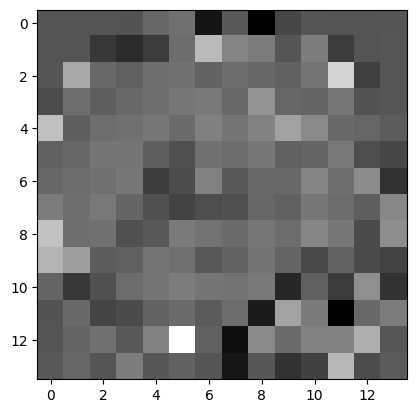

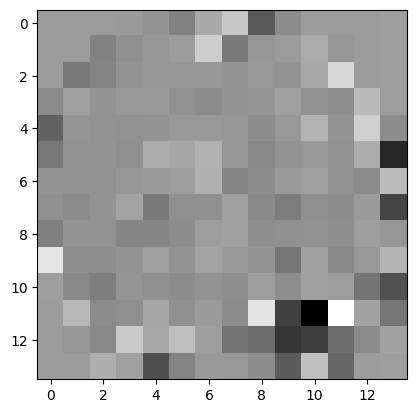

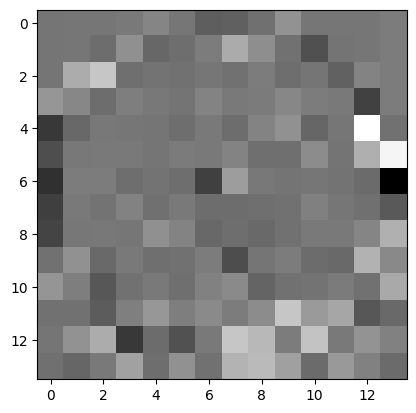

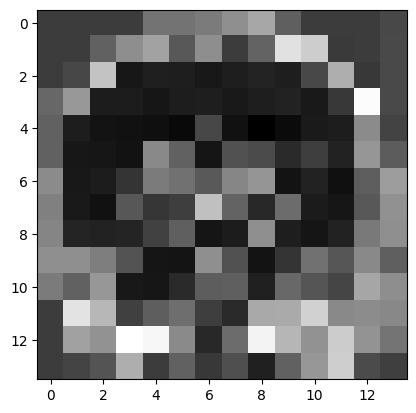

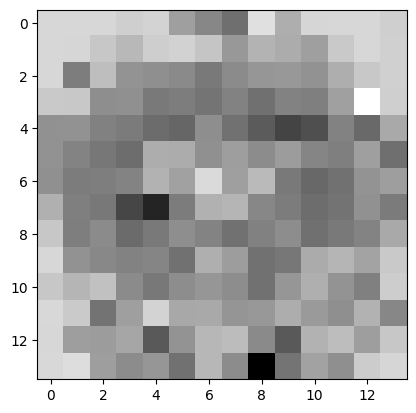

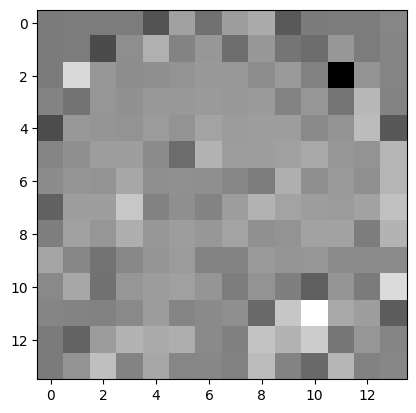

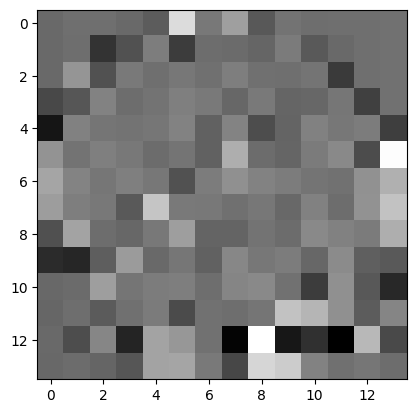

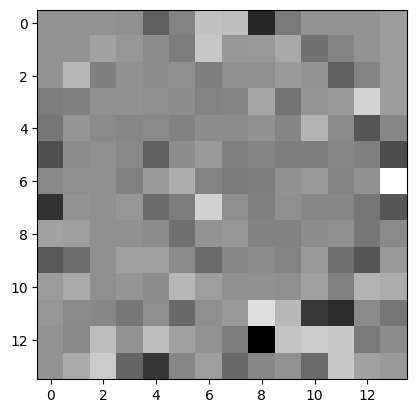

In [37]:
#visualize
layer_outputs = {}

def hook_fn(module, input, output):
    """Store the output of each layer."""
    layer_outputs[module] = output

# Register hooks on all layers
hooks = []
for name, module in model.named_modules():
    hook = module.register_forward_hook(hook_fn)
    hooks.append(hook)


import torch
from torchvision import transforms
from PIL import Image

# Load and preprocess an image
image_path = "/kaggle/input/gli-mem/Modified_dataset2/test/glioma_tumor/image(14).jpg"
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension

# Forward pass through the model
model.eval().to('cuda')
with torch.no_grad():
    outputs = model(image)



import matplotlib.pyplot as plt

# Visualize feature maps from the first layer
for layer, output in layer_outputs.items():
    print(f"Layer: {layer}")
    print(f"Output Shape: {output.shape}")
    print("-" * 50)

    if len(output.shape) == 4:  # Feature maps: [B, C, H, W]
        feature_maps = output[0]  # First image in the batch
        print(f"Visualizing features from: {layer}")

        # Plot the first 8 feature maps
        for i in range(min(8, feature_maps.size(0))):
            # plt.subplot(1, 8, i + 1)
            plt.imshow(feature_maps[i].detach().cpu().numpy(), cmap="gray")
            # plt.axis("off")
            plt.show()
        break

for hook in hooks:
    hook.remove()
